<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверим *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import sweetviz as sv
#import pandas_profiling as pp

from random import randint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты на месте
</div>


In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Признаки:
- RowNumber — индекс строки в данных (int64)
- CustomerId — уникальный идентификатор клиента (int64)
- Surname — фамилия (object)
- CreditScore — кредитный рейтинг (int64)
- Geography — страна проживания (object)
- Gender — пол (object)
- Age — возраст (int64)
- Tenure — количество недвижимости у клиента (float64)
- Balance — баланс на счёте (float64)
- NumOfProducts — количество продуктов банка, используемых клиентом (int64)
- HasCrCard — наличие кредитной карты (int64)
- IsActiveMember — активность клиента (int64)
- EstimatedSalary — предполагаемая зарплата (float64) ### Целевой признак:
- Exited — факт ухода клиента (int64)

В наших данных присутствуют столбцы, которые нам не нужны, удалим их. 

Также есть пропуски в значении Tenure (количество недвижимости). Можно предположить, что у клиента недвижимость отсутствует, думаю пропуски лучше заменить на 0. 

Удалим столбецы RowNumber, CustomerId и Surname. Они не нужны при исследовании модели. 

RowNumber повторяет индекс датафрейма, CustomerId - случайный или последовательный номер, который никак не зависит от действий пользователя. Surname - признак, который отличается от человека к человеку и является именем в обществе. Это не гарант того, что клиент останется или уйдет.

In [4]:
del_col = ['RowNumber', 'CustomerId', 'Surname']
data = data.drop(del_col, axis=1)

Заполним пропуски 0 в Tenure

In [11]:
data['Tenure'] = data['Tenure'].fillna(randint(0, 10)).astype('int64')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [13]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [14]:
#pandas_profiling.ProfileReport(data)
#report = sv.analyze(data)

## Исследование задачи

Создадим датафрейм, созданный по методу прямого кодирования с защитой от дамми-ловушки.

In [15]:
ohe_churn_data = pd.get_dummies(data, drop_first=True)
ohe_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


Будем использовать следующие модели:
- Дерево решения
- Случайный лес
- Логистическая регрессия

Разобъем данные по принципу 60/20/20.

In [16]:
target = ohe_churn_data['Exited']
features = ohe_churn_data.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                              random_state=12345 )
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


Посмотрим, какой существует дисбаланс классов.

In [17]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Соотношение классов 1:4. Изучим модели без исправление баланса.

Начнем с модели Дерево решения, проведем исследование при разном значении max_depth.

In [36]:
%%time

for depth_dtc in range(2, 30):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth_dtc)
    model_dtc.fit(features_train, target_train)
    predicted_valid = model_dtc.predict(features_valid)
    print('Max depth', depth_dtc, 'F1-score', f1_score(target_valid, predicted_valid))

Max depth 2 F1-score 0.5217391304347825
Max depth 3 F1-score 0.4234875444839857
Max depth 4 F1-score 0.5528700906344411
Max depth 5 F1-score 0.5406249999999999
Max depth 6 F1-score 0.5696969696969697
Max depth 7 F1-score 0.5320813771517998
Max depth 8 F1-score 0.5449010654490106
Max depth 9 F1-score 0.5766526019690578
Max depth 10 F1-score 0.5227272727272727
Max depth 11 F1-score 0.5226666666666667
Max depth 12 F1-score 0.5149544863459038
Max depth 13 F1-score 0.5301837270341208
Max depth 14 F1-score 0.51010101010101
Max depth 15 F1-score 0.5062972292191436
Max depth 16 F1-score 0.4930817610062893
Max depth 17 F1-score 0.5036319612590799
Max depth 18 F1-score 0.4889975550122249
Max depth 19 F1-score 0.4940047961630695
Max depth 20 F1-score 0.4981684981684981
Max depth 21 F1-score 0.5
Max depth 22 F1-score 0.5012165450121654
Max depth 23 F1-score 0.5012165450121654
Max depth 24 F1-score 0.5012165450121654
Max depth 25 F1-score 0.5012165450121654
Max depth 26 F1-score 0.5012165450121654


Как видим, лучший результат у max_depth = 9. F1 = 0.576

Теперь рассмотрим, как поведет себя Случайный лес.

In [37]:
%%time

for estimator_rfc in range(50, 300, 10):
    model_rfc =  RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc)
    model_rfc.fit(features_train, target_train)
    predicted_valid = model_rfc.predict(features_valid)
    print('N estimators', estimator_rfc, 'F1', f1_score(target_valid, predicted_valid))

N estimators 50 F1 0.5606060606060607
N estimators 60 F1 0.563165905631659
N estimators 70 F1 0.56797583081571
N estimators 80 F1 0.5731523378582202
N estimators 90 F1 0.5705705705705705
N estimators 100 F1 0.5692771084337349
N estimators 110 F1 0.5735735735735735
N estimators 120 F1 0.5735735735735735
N estimators 130 F1 0.574436090225564
N estimators 140 F1 0.5791855203619909
N estimators 150 F1 0.5783132530120483
N estimators 160 F1 0.5791855203619909
N estimators 170 F1 0.5744680851063829
N estimators 180 F1 0.5770392749244713
N estimators 190 F1 0.5791855203619909
N estimators 200 F1 0.5779122541603631
N estimators 210 F1 0.575301204819277
N estimators 220 F1 0.575712143928036
N estimators 230 F1 0.575301204819277
N estimators 240 F1 0.5847076461769116
N estimators 250 F1 0.5868263473053892
N estimators 260 F1 0.5829596412556054
N estimators 270 F1 0.5863095238095238
N estimators 280 F1 0.5892857142857143
N estimators 290 F1 0.588410104011887
CPU times: user 29.6 s, sys: 58.1 ms, 

Лучший результат был получен в районе 280-290 n_estimators, для более точного результата сделаем исследование с шагом 1.

In [38]:
%%time

for estimator_rfc in range(280, 290, 1):
    model_rfc =  RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc)
    model_rfc.fit(features_train, target_train)
    predicted_valid = model_rfc.predict(features_valid)
    print('N estimators', estimator_rfc, 'F1', f1_score(target_valid, predicted_valid))

N estimators 280 F1 0.5892857142857143
N estimators 281 F1 0.5892857142857143
N estimators 282 F1 0.5871833084947838
N estimators 283 F1 0.5913818722139673
N estimators 284 F1 0.5892857142857143
N estimators 285 F1 0.588410104011887
N estimators 286 F1 0.588410104011887
N estimators 287 F1 0.591715976331361
N estimators 288 F1 0.5905044510385756
N estimators 289 F1 0.5905044510385756
CPU times: user 19.5 s, sys: 51.2 ms, total: 19.6 s
Wall time: 19.6 s


Как видим, лучший результат достигнут на глубине 287. F1 = 0.5917

А теперь изучим, как работает Логистической регрессии. 

In [26]:
%%time

model_lr =  LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)
predicted_valid = model_lr.predict(features_valid)
print('F1', f1_score(target_valid, predicted_valid))

F1 0.08385744234800838
CPU times: user 43.2 ms, sys: 40.1 ms, total: 83.3 ms
Wall time: 39 ms


Результаты низкие. Возможно precision или recall низкий и близок к 0.

Проведем оценку accuracy, precision, recall, а также F-метрику.

In [39]:
%%time

model_dtc_rate = DecisionTreeClassifier(random_state=12345, max_depth=7)
model_dtc_rate.fit(features_train, target_train)
predicted_valid = model_dtc_rate.predict(features_valid)
print('Дерево решения')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model_rfc_rate = RandomForestClassifier(random_state=12345, n_estimators=53)
model_rfc_rate.fit(features_train, target_train)
predicted_valid = model_rfc_rate.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model_lr_rate = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_rate.fit(features_train, target_train)
predicted_valid = model_lr_rate.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Дерево решения
Точность попадания по классам 0.8505
Precision 0.7692307692307693
Recall 0.40669856459330145
F1 0.5320813771517998

Случайный лес
Точность попадания по классам 0.854
Precision 0.7540322580645161
Recall 0.4473684210526316
F1 0.5615615615615616

Логистическая регрессия
Точность попадания по классам 0.7815
Precision 0.3389830508474576
Recall 0.04784688995215311
F1 0.08385744234800838

CPU times: user 412 ms, sys: 51.8 ms, total: 464 ms
Wall time: 465 ms


Проведем построение ROC-кривой для каждой модели и выведем показатель AUC-ROC.

AUC-ROC DecisionTreeClassifier 0.8152322177124227
AUC-ROC RandomForestClassifier 0.8390883685480797
AUC-ROC LogisticRegression 0.6727841324953574


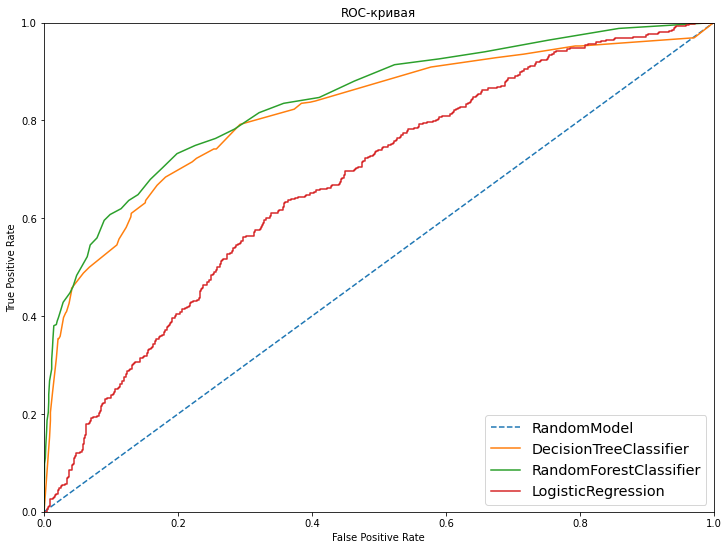

In [28]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model_roc_dtc = DecisionTreeClassifier(random_state=12345, max_depth=7)
model_roc_dtc.fit(features_train, target_train)
probabilities_valid = model_roc_dtc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model_roc_rfc = RandomForestClassifier(random_state=12345, n_estimators=53)
model_roc_rfc.fit(features_train, target_train)
probabilities_valid = model_roc_rfc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model_roc_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_roc_lr.fit(features_train, target_train)
probabilities_valid = model_roc_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression', auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

По полученным реззультатам можно заметить, что метрика F1 и AUC-ROC лучшая на Случайном лесе. 

<b>Вывод</b>

Рассматривая данные с дисбалансом тремя моделями можно сделать вывод, что саммая лучшая модель оказалась Случайный лес. При лучшем значении max_depth=287, мы имеем F1 меру = 0,5917 на тестовой (валидной) выборке.

## Борьба с дисбалансом

Для борьбы с дисбалансом выполним сравнение моделей:
- С взвешенными классами
- С увеличенной выборкой
- С уменьшенной выборкой


Изучим возможности моделей по взвешиванию классов.

In [40]:
%%time

model_dtc_disb = DecisionTreeClassifier(random_state=12345, max_depth=7, class_weight='balanced')
model_dtc_disb.fit(features_train, target_train)
predicted_valid = model_dtc_disb.predict(features_valid)
print('Дерево решения')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model_rfc_disb = RandomForestClassifier(random_state=12345, n_estimators=53, class_weight='balanced')
model_rfc_disb.fit(features_train, target_train)
predicted_valid = model_rfc_disb.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model_lr_disb = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lr_disb.fit(features_train, target_train)
predicted_valid = model_lr_disb.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()


Дерево решения
Точность попадания по классам 0.7775
Precision 0.47684391080617494
Recall 0.6650717703349283
F1 0.5554445554445555

Случайный лес
Точность попадания по классам 0.863
Precision 0.7950819672131147
Recall 0.46411483253588515
F1 0.5861027190332326

Логистическая регрессия
Точность попадания по классам 0.6925
Precision 0.37420178799489145
Recall 0.7009569377990431
F1 0.4879267277268943

CPU times: user 444 ms, sys: 35.9 ms, total: 480 ms
Wall time: 476 ms


Как мы видим, F-мера упала у Дерева решения и Случайного леса, но выросла в разы у Логистической регресии.

Исследуем способ увеличения значений класса 1. Для этого используем функцию upsample

In [41]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(target_upsampled.value_counts())

0    4804
1    4784
Name: Exited, dtype: int64


In [42]:
%%time

model_dtc_upsample = DecisionTreeClassifier(random_state=12345, max_depth=7)
model_dtc_upsample.fit(features_upsampled, target_upsampled)
predicted_valid = model_dtc_upsample.predict(features_valid)
print('Дерево решения')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model_rfc_upsample = RandomForestClassifier(random_state=12345, n_estimators=53)
model_rfc_upsample.fit(features_upsampled, target_upsampled)
predicted_valid = model_rfc_upsample.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

modeL_lr_upsample = LogisticRegression(random_state=12345, solver='liblinear')
modeL_lr_upsample.fit(features_upsampled, target_upsampled)
predicted_valid = modeL_lr_upsample.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Дерево решения
Точность попадания по классам 0.779
Precision 0.4793103448275862
Recall 0.6650717703349283
F1 0.5571142284569138

Случайный лес
Точность попадания по классам 0.848
Precision 0.6619318181818182
Recall 0.5574162679425837
F1 0.6051948051948052

Логистическая регрессия
Точность попадания по классам 0.6595
Precision 0.3406060606060606
Recall 0.6722488038277512
F1 0.45213193885760256

CPU times: user 633 ms, sys: 68.3 ms, total: 701 ms
Wall time: 629 ms


F-мера стала лучше у Случайного леса, Логистической регресии по сравнению с дисбалансными данными. 
Лучшей моделью по F-мера стал Случайный лес с тренировочными данными, где увеличен класс 1.

Исследуем способ уменьшения значений класса 0, для этого используем функцию downsample.

In [43]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(target_downsampled.value_counts())

0    1201
1    1196
Name: Exited, dtype: int64


In [44]:
%%time

model_dtc_downsample = DecisionTreeClassifier(random_state=12345, max_depth=7)
model_dtc_downsample.fit(features_downsampled, target_downsampled)
predicted_valid = model_dtc_downsample.predict(features_valid)
print('Дерево решения')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model_rfc_downsample = RandomForestClassifier(random_state=12345, n_estimators=53)
model_rfc_downsample.fit(features_downsampled, target_downsampled)
predicted_valid = model_rfc_downsample.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model_lr_downsample = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_downsample.fit(features_downsampled, target_downsampled)
predicted_valid = model_lr_downsample.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Дерево решения
Точность попадания по классам 0.7365
Precision 0.4222539229671897
Recall 0.7081339712918661
F1 0.5290437890974085

Случайный лес
Точность попадания по классам 0.77
Precision 0.46846846846846846
Recall 0.7464114832535885
F1 0.5756457564575646

Логистическая регрессия
Точность попадания по классам 0.654
Precision 0.33729216152019004
Recall 0.6794258373205742
F1 0.4507936507936508

CPU times: user 247 ms, sys: 40 ms, total: 287 ms
Wall time: 241 ms


Показатели Логистической регрессии выросли. Дерево решения и Случайный лес показали себя хуже.

Выведем ROC-кривую и AUC-ROC для посленнего измененного баланса.

AUC-ROC DecisionTreeClassifier 0.7945434281601026
AUC-ROC RandomForestClassifier 0.8312724187782409
AUC-ROC LogisticRegression 0.7195029004530635


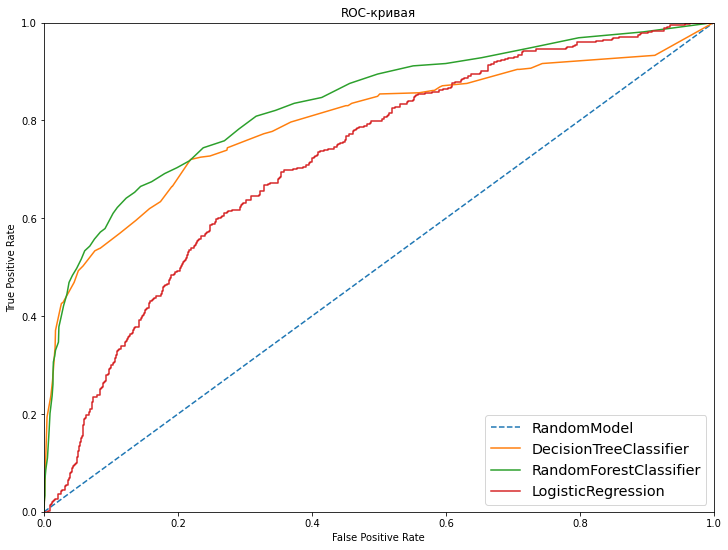

In [45]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model_dtc_roc_new = DecisionTreeClassifier(random_state=12345, max_depth=7)
model_dtc_roc_new.fit(features_upsampled, target_upsampled)
probabilities_valid = model_dtc_roc_new.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model_rfc_roc_new = RandomForestClassifier(random_state=12345, n_estimators=53)
model_rfc_roc_new.fit(features_upsampled, target_upsampled)
probabilities_valid = model_rfc_roc_new.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model_lr_roc_new = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_roc_new.fit(features_upsampled, target_upsampled)
probabilities_valid = model_lr_roc_new.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Дисбаланс повлиял на модели в худшую сторону. Лучшим решением стало увеличение классов 1 в тренировочной выборке.

Выравние классов в выборке привело к резкому росту параметра recall и небольшому понижению percison. 

Но в целом F-мера выросла.

## Тестирование модели

К тестовой выборке примем модель Случайного леса. Исследуем гиперпараметры и улучшим F-меру модели.

In [48]:
%%time

for estimator_rfc_train in range(10, 500, 10):
    model_rfc_train =  RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train)
    model_rfc_train.fit(features_upsampled, target_upsampled)
    predicted_valid = model_rfc_train.predict(features_valid)
    print('N estimators', estimator_rfc_train, 'F1', f1_score(target_valid, predicted_valid))

N estimators 10 F1 0.5767690253671564
N estimators 20 F1 0.6058201058201058
N estimators 30 F1 0.5949535192563081
N estimators 40 F1 0.6073298429319371
N estimators 50 F1 0.6065359477124183
N estimators 60 F1 0.6062992125984252
N estimators 70 F1 0.6115485564304461
N estimators 80 F1 0.6089238845144357
N estimators 90 F1 0.6129458388375165
N estimators 100 F1 0.6129458388375165
N estimators 110 F1 0.6068601583113458
N estimators 120 F1 0.6097240473061761
N estimators 130 F1 0.6055045871559633
N estimators 140 F1 0.6111111111111113
N estimators 150 F1 0.6052631578947368
N estimators 160 F1 0.6105263157894737
N estimators 170 F1 0.61133069828722
N estimators 180 F1 0.613157894736842
N estimators 190 F1 0.6083550913838119
N estimators 200 F1 0.6052631578947368
N estimators 210 F1 0.5989445910290238
N estimators 220 F1 0.5992115637319316
N estimators 230 F1 0.6010498687664041
N estimators 240 F1 0.6020942408376964
N estimators 250 F1 0.6005221932114881
N estimators 260 F1 0.599476439790575

Лучший результат лежит в диапазоне 180-190, изучим подробнее.

In [50]:
%%time

for estimator_rfc_train in range(180, 190):
    model_rfc_train =  RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train)
    model_rfc_train.fit(features_upsampled, target_upsampled)
    predicted_valid = model_rfc_train.predict(features_valid)
    print('N estimators', estimator_rfc_train, 'F1', f1_score(target_valid, predicted_valid))

N estimators 180 F1 0.613157894736842
N estimators 181 F1 0.6091503267973857
N estimators 182 F1 0.6097240473061761
N estimators 183 F1 0.6083550913838119
N estimators 184 F1 0.6099476439790575
N estimators 185 F1 0.6075619295958278
N estimators 186 F1 0.6073298429319371
N estimators 187 F1 0.6075619295958278
N estimators 188 F1 0.6083550913838119
N estimators 189 F1 0.6075619295958278
CPU times: user 16.6 s, sys: 71.9 ms, total: 16.7 s
Wall time: 16.7 s


Лучший F1 = 0.6131 при n_estimators = 180

In [51]:
%%time

model_rfc_train =  RandomForestClassifier(random_state=12345, n_estimators=180, criterion='entropy')
model_rfc_train.fit(features_upsampled, target_upsampled)
predicted_valid = model_rfc_train.predict(features_valid)
print('F1', f1_score(target_valid, predicted_valid))

F1 0.6086956521739131
CPU times: user 1.95 s, sys: 16 ms, total: 1.97 s
Wall time: 1.97 s


Изменим гиперпараметр min_samples_split.

In [53]:
%%time

for samples_split in range(1, 11):
    model_rfc_ss =  RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=samples_split/10)
    model_rfc_ss.fit(features_upsampled, target_upsampled)
    predicted_valid = model_rfc_ss.predict(features_valid)
    print('Samples_split', samples_split/10,'F1', f1_score(target_valid, predicted_valid))
    
for samples_split in range(2, 11):
    model_rfc_ss =  RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=samples_split)
    model_rfc_ss.fit(features_upsampled, target_upsampled)
    predicted_valid = model_rfc_ss.predict(features_valid)
    print('Samples_split', samples_split,'F1', f1_score(target_valid, predicted_valid))

Samples_split 0.1 F1 0.5823970037453183
Samples_split 0.2 F1 0.5779816513761468
Samples_split 0.3 F1 0.5448154657293498
Samples_split 0.4 F1 0.5550500454959053
Samples_split 0.5 F1 0.5690140845070423
Samples_split 0.6 F1 0.5439252336448598
Samples_split 0.7 F1 0.0
Samples_split 0.8 F1 0.0
Samples_split 0.9 F1 0.0
Samples_split 1.0 F1 0.0
Samples_split 2 F1 0.6075619295958278
Samples_split 3 F1 0.6108897742363878
Samples_split 4 F1 0.6084656084656085
Samples_split 5 F1 0.6121919584954605
Samples_split 6 F1 0.6235446313065977
Samples_split 7 F1 0.617906683480454
Samples_split 8 F1 0.617906683480454
Samples_split 9 F1 0.6189889025893959
Samples_split 10 F1 0.6167076167076168
CPU times: user 20.8 s, sys: 148 ms, total: 21 s
Wall time: 21 s


Лучший F1 получен при min_samples_split=6.

Изменим гиперпараметр min_samples_leaf.

In [55]:
%%time

for samples_leaf in range(1, 6):
    model_rfc_sl =  RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=5, 
                                    min_samples_leaf= samples_leaf/10)
    model_rfc_sl.fit(features_upsampled, target_upsampled)
    predicted_valid = model_rfc_sl.predict(features_valid)
    print('Samples_leaf', samples_leaf/10,'F1', f1_score(target_valid, predicted_valid))
    
for samples_leaf in range(1, 11):
    model_rfc_sl =  RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=5,
                                   min_samples_leaf= samples_leaf)
    model_rfc_sl.fit(features_upsampled, target_upsampled)
    predicted_valid = model_rfc_sl.predict(features_valid)
    print('Samples_leaf', samples_leaf,'F1', f1_score(target_valid, predicted_valid))

Samples_leaf 0.1 F1 0.5446182152713892
Samples_leaf 0.2 F1 0.519962859795729
Samples_leaf 0.3 F1 0.4879668049792531
Samples_leaf 0.4 F1 0.0
Samples_leaf 0.5 F1 0.0
Samples_leaf 1 F1 0.6121919584954605
Samples_leaf 2 F1 0.6153846153846153
Samples_leaf 3 F1 0.6261904761904763
Samples_leaf 4 F1 0.6287703016241298
Samples_leaf 5 F1 0.6258503401360545
Samples_leaf 6 F1 0.6312292358803987
Samples_leaf 7 F1 0.6211453744493393
Samples_leaf 8 F1 0.6163793103448275
Samples_leaf 9 F1 0.6216505894962486
Samples_leaf 10 F1 0.6283280085197017
CPU times: user 18.4 s, sys: 63.8 ms, total: 18.5 s
Wall time: 18.5 s


Лучший показатель min_samples_leaf = 6.

Проверим на тестовой выборке четыре модели: на дисбалансных данных и сбалансированных: со взвешенными классами, усечением 0 класса и расширением класса 1.

In [56]:
model_rfc_test = RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=6,
                                   min_samples_leaf=6)
model_rfc_test.fit(features_train, target_train)
predicted_test = model_rfc_test.predict(features_test)
print('Случайный лес - дисбаланс классов')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model_rfc_test = RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=6,
                                   min_samples_leaf=6, class_weight='balanced')
model_rfc_test.fit(features_train, target_train)
predicted_test = model_rfc_test.predict(features_test)
print('Случайный лес - взвешенные классы')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model_rfc_test = RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=6,
                                   min_samples_leaf=6)
model_rfc_test.fit(features_downsampled, target_downsampled)
predicted_test = model_rfc_test.predict(features_test)
print('Случайный лес - уменьшенное количество классов 0')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model_rfc_test = RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=6,
                                   min_samples_leaf=6)
model_rfc_test.fit(features_upsampled, target_upsampled)
predicted_test = model_rfc_test.predict(features_test)
print('Случайный лес - увеличенное количество классов 1')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

Случайный лес - дисбаланс классов
Точность попадания по классам 0.8425
Precision 0.7454545454545455
Recall 0.3877068557919622
F1 0.5101088646967341

Случайный лес - взвешенные классы
Точность попадания по классам 0.8355
Precision 0.6063348416289592
Recall 0.6335697399527187
F1 0.6196531791907514

Случайный лес - уменьшенное количество классов 0
Точность попадания по классам 0.778
Precision 0.48406676783004554
Recall 0.7541371158392435
F1 0.589648798521257

Случайный лес - увеличенное количество классов 1
Точность попадания по классам 0.826
Precision 0.5786163522012578
Recall 0.6524822695035462
F1 0.6133333333333334



In [58]:
model_rfc_test = RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=6,
                                   min_samples_leaf=6)
model_rfc_test.fit(features_train, target_train)
predicted_test = model_rfc_test.predict(features_test)
print('Случайный лес - дисбаланс классов')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model_rfc_test = RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=6,
                                   min_samples_leaf=6, class_weight='balanced')
model_rfc_test.fit(features_train, target_train)
predicted_test = model_rfc_test.predict(features_test)
print('Случайный лес - взвешенные классы')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model_rfc_test = RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=6,
                                   min_samples_leaf=6)
model_rfc_test.fit(features_downsampled, target_downsampled)
predicted_test = model_rfc_test.predict(features_test)
print('Случайный лес - уменьшенное количество классов 0')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

model_rfc_test = RandomForestClassifier(random_state=12345, n_estimators=estimator_rfc_train, min_samples_split=6,
                                   min_samples_leaf=6)
model_rfc_test.fit(features_upsampled, target_upsampled)
predicted_test = model_rfc_test.predict(features_test)
print('Случайный лес - увеличенное количество классов 1')
print('Точность попадания по классам', accuracy_score(target_test, predicted_test))
print('Precision', precision_score(target_test, predicted_test))
print('Recall', recall_score(target_test, predicted_test))
print('F1', f1_score(target_test, predicted_test))
print()

Случайный лес - дисбаланс классов
Точность попадания по классам 0.8425
Precision 0.7454545454545455
Recall 0.3877068557919622
F1 0.5101088646967341

Случайный лес - взвешенные классы
Точность попадания по классам 0.8355
Precision 0.6063348416289592
Recall 0.6335697399527187
F1 0.6196531791907514

Случайный лес - уменьшенное количество классов 0
Точность попадания по классам 0.778
Precision 0.48406676783004554
Recall 0.7541371158392435
F1 0.589648798521257

Случайный лес - увеличенное количество классов 1
Точность попадания по классам 0.826
Precision 0.5786163522012578
Recall 0.6524822695035462
F1 0.6133333333333334



AUC-ROC RandomForestClassifier - disbalanced 0.8611751972428723
AUC-ROC RandomForestClassifier - balanced by class weight 0.8588755919534803
AUC-ROC RandomForestClassifier - balanced by reduce 0 class 0.8506830607236712
AUC-ROC RandomForestClassifier - balanced by grow 1 class 0.8578517129361042


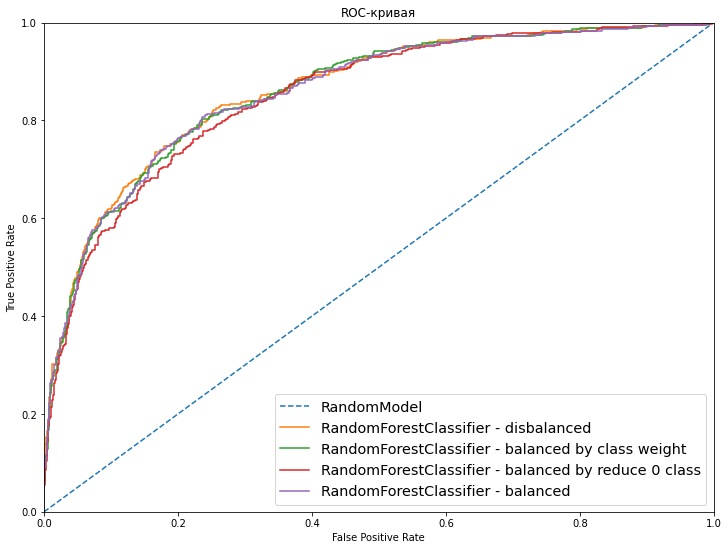

In [31]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = RandomForestClassifier(random_state=12345, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - disbalanced',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - disbalanced')

model = RandomForestClassifier(random_state=12345, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by class weight',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced by class weight')

model = RandomForestClassifier(random_state=12345, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by reduce 0 class',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced by reduce 0 class')

model = RandomForestClassifier(random_state=12345, n_estimators=estimator, min_samples_split=5,
                                   min_samples_leaf=7)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by grow 1 class',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

<b>Вывод:</b>
2 из 4 моделей достигли минимума F-меры на тестовых данных: модель случайного леса со взвешенными весами классов и модель с увеличенным количеством класса 1.

Видно, что взвешивание классов дает результат лучше для данного набора данных. Percision падает, recall растет, и в целом F-мера имеет небольшой прирост. Баланс классов повышает охват необходимых данных.

Оценивая адеватность модели можно заметить, что AUC-ROC дисбалансной модели и модели с весами примерно одинаково предсказывают вероятность ухода клиента.

В результате исследования была получена модель с лучшими показателями как по F1-мере, так и по AUC-ROC - Случайный лес: взвешенные классы.

<b>Итоговый вывод</b>

При работе с проектом было выполнено:

1. Изучены данные. Разбиты данные на тренировочную, валидационную и тестовую выборку.
2. Исследована задача. Проверены модели на данных без изменений.
3. Скоректирован балланс класса. Изменен вес класса.
4. Получена улученная модель. Проведен поиск гиперпараметров.
5. Проведен финальный тест.

Обученная модель Случайного леса со взвешенными классами имеет достаточную адекватность, подтвержденная ее значением AUC-ROC = 0.863. Это лучше, чем Случайная модель предсказывания (AUC-ROC = 0.5). Точность попадания по классам 0.834, precision 0.58, recall 0.649 и f1 0.612. Модель старается собрать больше данных, чем показать верную точность (recall > precision). Процент попадания в классы достаточно высокий.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*